In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

import bacco
import baccoemu

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import utils

%load_ext autoreload
%autoreload 2

Importing pyfftw first


2024-06-10 13:05:13.672567: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-10 13:05:17.154936: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-10 13:05:17.162848: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 13:06:13.374787: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-10 13:07:47.790349: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gp

In [4]:
npart = 512
box_size = 1000.0
param_names = ['omega_m', 'omega_baryon', 'h', 'n_s', 'sigma_8']

## Load emus

In [2]:
emu_mpk_ext, emu_bounds_mpk_ext, emu_param_names_mpk_ext = utils.load_emu(emu_name='mpk_extended')
emu_bounds_dict_mpk_ext = dict(zip(emu_param_names_mpk_ext, emu_bounds_mpk_ext))

Loading sigma8 emulator...
HIIII
Sigma8 emulator loaded in memory.
Loading linear emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using v

Linear emulator loaded in memory.
Loading no-wiggles emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


No-wiggles emulator loaded in memory.
Loading non-linear emulator...
Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Quijote pks

In [60]:
param_names_2_emu_param_names = {'sigma_8': 'sigma8_cold',
                                 'omega_cold': 'omega_cold',
                                 'omega_baryon': 'omega_baryon',
                                 'h': 'hubble',
                                 'n_s': 'ns'}
emu_param_names = [param_names_2_emu_param_names[param_name] for param_name in param_names if param_name in param_names_2_emu_param_names]

cosmo_params = {
    'neutrino_mass' :  0.0,
    'w0'            : -1.0,
    'wa'            :  0.0,
    'expfactor'     :  1
}

In [61]:
ngrid = 512
box_size = 1000.

idxs_LH = np.array([10,29,37,40,70,85,127,158,165,184,208,220,240,254,267,274,293,305,336,374,375,388,433,444,
                      464,502,534,542,574,598,605,628,652,663,676,700,702,721,737,762,809,822,825,837,853,864,882,
                      899,901,911,939,948,950,951,964,976,977,1016,1022,1041,1050,1060,1082,1091,1103,1114,1147,
                      1157,1173,1175,1219,1222,1299,1309,1314,1317,1331,1365,1372,1378,1391,1397,1418,1444,1459,
                      1510,1512,1513,1515,1517,1533,1553,1567,1568,1599,1622,1642,1657,1659,1667])

idxs_LH = idxs_LH[:22]

In [62]:
tag_pk = '_b0000'
dir_pks_sim = f'../data/pks_quijote_LH/pks_sim{tag_pk}'
dir_pks_pred = f'../data/pks_quijote_LH/pks_pred{tag_pk}'
dir_mocks = '/cosmos_storage/home/mpelle/Yin_data/Quijote' #need for params

fn_bias_vector = f'{dir_pks_sim}/bias_params.txt' #same for sim and pred
bias_params = np.loadtxt(fn_bias_vector)
param_names = ['omega_m', 'omega_baryon', 'h', 'n_s', 'sigma_8']

In [63]:
idxs_LH_inbounds = []
theta = []

for i, idx_LH in enumerate(idxs_LH):    
#for i, idx_LH in enumerate(idxs_LH[:48]):    

    idx_LH_str = f'{idx_LH:04}' 

    fn_params = f'{dir_mocks}/LH{idx_LH_str}/param_{idx_LH_str}.txt'
    param_vals = np.loadtxt(fn_params)
    param_dict = dict(zip(param_names, param_vals))
    out_of_bounds = False # til we check, below

    if i % 100 == 0:
        print(i)
    for param_name in param_names:
        if param_name=='omega_m':
            # no neutrinos, so omega_cold = omega_m
            emu_param_name = 'omega_cold'
        else:
            emu_param_name = param_names_2_emu_param_names[param_name]
        cosmo_params[emu_param_name] = param_dict[param_name]
        
        # print(param_name, param_dict[param_name])
        # print(emu_param_name, emu_bounds_dict[emu_param_name])
        
        # check in bounds
        if (param_dict[param_name] < emu_bounds_dict_mpk_ext[emu_param_name][0]) or \
           (param_dict[param_name] > emu_bounds_dict_mpk_ext[emu_param_name][1]):
            #print(f"params for {idx_LH} OOB!")    
            out_of_bounds = True
            break
    
    if out_of_bounds:
        continue
    
    idxs_LH_inbounds.append(idx_LH)
    theta.append(param_vals)

theta = np.array(theta)

print(len(idxs_LH_inbounds))

0
17


In [66]:
pks_sim = []
pks_pred = []
for idx_LH in idxs_LH_inbounds:
    idx_LH_str = f'{idx_LH:04}' 
    
    fn_pk_sim = f'{dir_pks_sim}/pk_{idx_LH_str}.npy'
    pks_sim.append( np.load(fn_pk_sim, allow_pickle=True).item() )
    
    fn_pk_pred = f'{dir_pks_pred}/pk_{idx_LH_str}.npy'
    pks_pred.append( np.load(fn_pk_pred, allow_pickle=True).item() )
    
Pk_sim = np.array([pk['pk'] for pk in pks_sim])
Pk_pred = np.array([pk['pk'] for pk in pks_pred])
gaussian_error_pk_sim = np.array([pk['pk_gaussian_error'] for pk in pks_sim])
gaussian_error_pk_pred = np.array([pk['pk_gaussian_error'] for pk in pks_pred])
k = pks_sim[0]['k']

In [67]:
Pk_emu = []
for i, idx_LH in enumerate(idxs_LH_inbounds):
    param_dict = dict(zip(param_names, theta[i]))
    for param_name in param_names:
        if param_name=='omega_m':
            # no neutrinos, so omega_cold = omega_m
            emu_param_name = 'omega_cold'
        else:
            emu_param_name = param_names_2_emu_param_names[param_name]
        cosmo_params[emu_param_name] = param_dict[param_name]
    
    #_, pk_model_unscaled, _ = emu_lbias.get_galaxy_real_pk(bias=bias_params, k=k, 
    #                                                       **cosmo_params)
    _, pk_model_unscaled, = emu_mpk_ext.get_nonlinear_pk(k=k, cold=True,
                                                           **cosmo_params)
    Pk_emu.append(pk_model_unscaled)
    
Pk_emu = np.array(Pk_emu)

/tmp/ipykernel_221072/2007368632.py:12: RuntimeWarning: divide by zero encountered in divide
  diff_Pksim_overPk = diff_Pksim/Pk_sim
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tmp/ipykernel_221072/2007368632.py:18: RuntimeWarning: divide by zero encountered in divide
  diff_Pkpred_overPk = diff_Pkpred/Pk_pred
/tmp/ipykernel_221072/2007368632.py:24: RuntimeWarning: invalid value encountered in divide
  diff_overPk = diff/Pk_sim


['emulated at true $\\theta$', 'Quijote simulation', 'map2map prediction']
['median', '16-84 percentile']


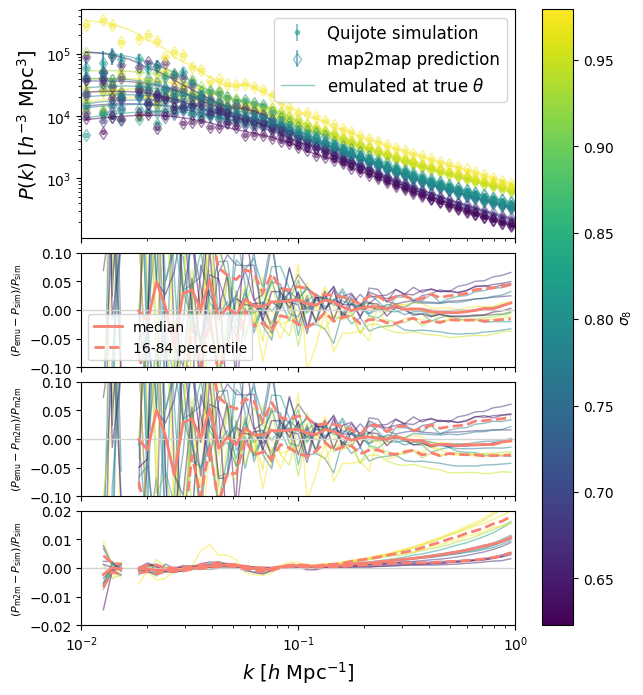

In [68]:
param_names_compare = ['sigma_8']

for param_name_compare in param_names_compare:
    idx_param = param_names.index(param_name_compare)
    param_vals = np.array([theta[i][idx_param] for i in range(theta.shape[0])])

    normalizer = mpl.colors.Normalize(vmin=np.min(param_vals), vmax=np.max(param_vals))
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=mpl.cm.viridis)#.to_rgba(cvals)
    colors = sm.to_rgba(param_vals)
      
    diff_Pksim = Pk_emu - Pk_sim
    diff_Pksim_overPk = diff_Pksim/Pk_sim
    diff_Pksim_overPk_16 = np.percentile(diff_Pksim_overPk, 16, axis=0)
    diff_Pksim_overPk_84 = np.percentile(diff_Pksim_overPk, 84, axis=0)
    diff_Pksim_overPk_med = np.median(diff_Pksim_overPk, axis=0)

    diff_Pkpred = Pk_emu - Pk_pred
    diff_Pkpred_overPk = diff_Pkpred/Pk_pred
    diff_Pkpred_overPk_16 = np.percentile(diff_Pkpred_overPk, 16, axis=0)
    diff_Pkpred_overPk_84 = np.percentile(diff_Pkpred_overPk, 84, axis=0)
    diff_Pkpred_overPk_med = np.median(diff_Pkpred_overPk, axis=0)

    diff = Pk_pred - Pk_sim
    diff_overPk = diff/Pk_sim
    diff_overPk_16 = np.percentile(diff_overPk, 16, axis=0)
    diff_overPk_84 = np.percentile(diff_overPk, 84, axis=0)
    diff_overPk_med = np.median(diff_overPk, axis=0)

    nrows, ncols = 4, 1
    fig, axarr = plt.subplots(nrows, ncols, figsize=(7,8), sharex=True, height_ratios=[2,1,1,1])
    plt.subplots_adjust(hspace=0.1)
        
    # a few examples
    #colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    #print(colors)
    lw = 1
    show_error_all = False
    first = True
    for i, idx_LH in enumerate(idxs_LH_inbounds):
    
        pk_model_unscaled = Pk_emu[i]
        
        label_true, label_emu, label_stdev = None, None, None
        if first:
            label_true = 'Quijote simulation'
            label_emu = r'emulated at true $\theta$'
            label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
            
        if first or show_error_all:
            axarr[0].errorbar(k, Pk_sim[i], yerr=gaussian_error_pk_sim[i], 
                            ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
            axarr[0].errorbar(k, Pk_pred[i], yerr=gaussian_error_pk_sim[i], ls='None', marker='d', markersize=6, alpha=0.5, 
                            label='map2map prediction', 
                        markerfacecolor='None', markeredgecolor=colors[i])
        else:
            axarr[0].plot(k, Pk_sim[i], ls='None', marker='o', markersize=3, alpha=0.5, color=colors[i])
            axarr[0].plot(k, Pk_pred[i], ls='None', marker='d', markersize=6, alpha=0.5,
                        markerfacecolor='None', markeredgecolor=colors[i])
        
        axarr[0].plot(k, pk_model_unscaled, ls='-', alpha=0.5, label=label_emu, color=colors[i], lw=lw)

        axarr[1].plot(k, diff_Pksim_overPk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        axarr[2].plot(k, diff_Pkpred_overPk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        axarr[3].plot(k, diff_overPk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
            
        first = False
        
    axarr[1].axhline(0, color='lightgrey', lw=1)
    axarr[2].axhline(0, color='lightgrey', lw=1)
    axarr[3].axhline(0, color='lightgrey', lw=1)

    ls_1sig='--'
    axarr[1].axhline(-1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[1].axhline(1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(-1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[3].axhline(-1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[3].axhline(1, color='lightgrey', lw=1, ls=ls_1sig)


    alpha_16_84 = 0.5
    axarr[1].plot(k, diff_Pksim_overPk_med, color='salmon', lw=2, label='median')
    axarr[1].plot(k, diff_Pksim_overPk_16, color='salmon', lw=2, ls='--', label='16-84 percentile')
    axarr[1].plot(k, diff_Pksim_overPk_84, color='salmon', lw=2, ls='--')

    axarr[2].plot(k, diff_Pkpred_overPk_med, color='salmon', lw=2)
    axarr[2].plot(k, diff_Pkpred_overPk_16, color='salmon', lw=2, ls='--')
    axarr[2].plot(k, diff_Pkpred_overPk_84, color='salmon', lw=2, ls='--')

    axarr[3].plot(k, diff_overPk_med, color='salmon', lw=2)
    axarr[3].plot(k, diff_overPk_16, color='salmon', lw=2, ls='--')
    axarr[3].plot(k, diff_overPk_84, color='salmon', lw=2, ls='--')

    # plot settings
    plt.xscale('log')
    axarr[0].set_yscale('log')
        
    plt.xlim(1e-2, 1)
    #axarr[0].set_ylim(1e3, 5e5)
    #axarr[0].set_ylim(1e2, 2e5)

    axarr[1].set_ylim(-0.1, 0.1)
    axarr[2].set_ylim(-0.1, 0.1)
    axarr[3].set_ylim(-0.02, 0.02)
        
    handles, labels = axarr[0].get_legend_handles_labels()
    print(labels)

    if len(handles)>1:
        #order = [1,0,2]
        order = [1,2,0]
        #order = [1,0]
        axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
    # axarr[0].legend(fontsize=12)
    handles, labels = axarr[1].get_legend_handles_labels()
    print(labels)
    axarr[1].legend(fontsize=10)

    plt.xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=14)
    axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=14)    
    fontsize_errs = 8
    axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{sim})/P_\text{sim}$', fontsize=fontsize_errs)
    axarr[2].set_ylabel(r'$(P_\text{emu}-P_\text{m2m})/P_\text{m2m}$', fontsize=fontsize_errs)
    axarr[3].set_ylabel(r'$(P_\text{m2m}-P_\text{sim})/P_\text{sim}$', fontsize=fontsize_errs)

    cbar = plt.colorbar(sm, ax=axarr.ravel().tolist())
    cbar.set_label(utils.param_label_dict[param_name_compare])

## Muchisimocks

In [54]:
# Careful, these are diff than quijote, so order of running this nb matters
param_names_2_emu_param_names = {'sigma_8': 'sigma8_cold',
                                 'omega_cold': 'omega_cold',
                                 'h': 'hubble',
                                 'n_s': 'ns'}
emu_param_names = [param_names_2_emu_param_names[param_name] for param_name in param_names]

In [55]:
cosmo_params_base = utils.setup_cosmo_emu(cosmo='quijote')
print(cosmo_params_base)

Setting up emulator cosmology
{'omega_cold': 0.3175, 'sigma8_cold': 0.834, 'omega_baryon': 0.049, 'ns': 0.9624, 'hubble': 0.6711, 'neutrino_mass': 0.0, 'w0': -1.0, 'wa': 0.0, 'expfactor': 1.0}


In [56]:
param_names_all = ['omega_cold', 'sigma_8', 'h', 'omega_baryon', 'n_s', 'seed']
param_names = ['omega_cold', 'sigma_8', 'h']
param_names_fixed = [name for name in param_names_all if name not in param_names]
idxs_param_names = [param_names_all.index(name) for name in param_names]

tag_pk = '_b0000'
dir_pks = f'../data/pks_cosmolib/pks{tag_pk}'

bias_params = np.loadtxt(f'{dir_pks}/bias_params.txt')

n_lib = 500
#n_lib = 5
dir_mocks = '../data/cosmolib'
theta = []
Pk = []
gaussian_error_pk = []
param_dict_fixed = {}
for idx_LH in range(n_lib):
    fn_fields = f'{dir_mocks}/LH{idx_LH}/Eulerian_fields_lr_{idx_LH}.npy'
    fn_params = f'{dir_mocks}/LH{idx_LH}/cosmo_{idx_LH}.txt'
    fn_pk = f'{dir_pks}/pk_{idx_LH}.npy'
    
    pk_obj = np.load(fn_pk, allow_pickle=True).item()
    Pk.append(pk_obj['pk'])
    gaussian_error_pk.append(pk_obj['pk_gaussian_error'])
    
    param_vals = np.loadtxt(fn_params)
    if idx_LH==0:
        for name in param_names_fixed:
            param_dict_fixed[name] = param_vals[param_names_all.index(name)]
    theta.append(param_vals[idxs_param_names])

Pk = np.array(Pk)
theta = np.array(theta)
gaussian_error_pk = np.array(gaussian_error_pk)

kk = pk_obj['k'] # all ks should be same so just grab one
print(len(kk))

30


In [57]:
# overall quantities
Pk_emu_mm = []
for i in range(Pk.shape[0]):
    cosmo_params = cosmo_params_base.copy()
    if i % 100 == 0:
        print(i)
    for pp in range(len(param_names)):
        cosmo_params[emu_param_names[pp]] = theta[i][pp]

    # _, pk_model_unscaled, _ = emu_lbias.get_galaxy_real_pk(bias=bias_params, k=kk, 
    #                                                     **cosmo_params)
    _, pk_model_unscaled, = emu_mpk_ext.get_nonlinear_pk(k=kk, cold=True,
                                                           **cosmo_params)
    Pk_emu_mm.append(pk_model_unscaled)
    
Pk_emu_mm = np.array(Pk_emu_mm)
print(Pk_emu_mm.shape)

0
100
200
300
400
(500, 30)


/tmp/ipykernel_221072/2190302501.py:39: RuntimeWarning: divide by zero encountered in divide
  axarr[1].plot(k, (Pk_emu_mm[i]-Pk[i])/gaussian_error_pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_221072/2190302501.py:40: RuntimeWarning: divide by zero encountered in divide
  axarr[2].plot(k, (Pk_emu_mm[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_221072/2190302501.py:46: RuntimeWarning: divide by zero encountered in divide
  diff_overG = diff_Pk/gaussian_error_pk
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tmp/ipykernel_221072/2190302501.py:51: RuntimeWarning: divide by zero encountered in divide
  diff_overPk = diff_Pk/Pk


[<matplotlib.lines.Line2D object at 0x2b93344543d0>, <ErrorbarContainer object of 3 artists>] ['emulated at true $\\theta$', 'map2map measured']
[<matplotlib.lines.Line2D object at 0x2b933387e410>, <matplotlib.lines.Line2D object at 0x2b9333597650>] ['median', '16-84 percentile']
[<matplotlib.lines.Line2D object at 0x2b9334845ad0>, <ErrorbarContainer object of 3 artists>] ['emulated at true $\\theta$', 'map2map measured']
[<matplotlib.lines.Line2D object at 0x2b933367a010>, <matplotlib.lines.Line2D object at 0x2b93238326d0>] ['median', '16-84 percentile']
[<matplotlib.lines.Line2D object at 0x2b9330afa5d0>, <ErrorbarContainer object of 3 artists>] ['emulated at true $\\theta$', 'map2map measured']
[<matplotlib.lines.Line2D object at 0x2b932b52a010>, <matplotlib.lines.Line2D object at 0x2b9332f36bd0>] ['median', '16-84 percentile']


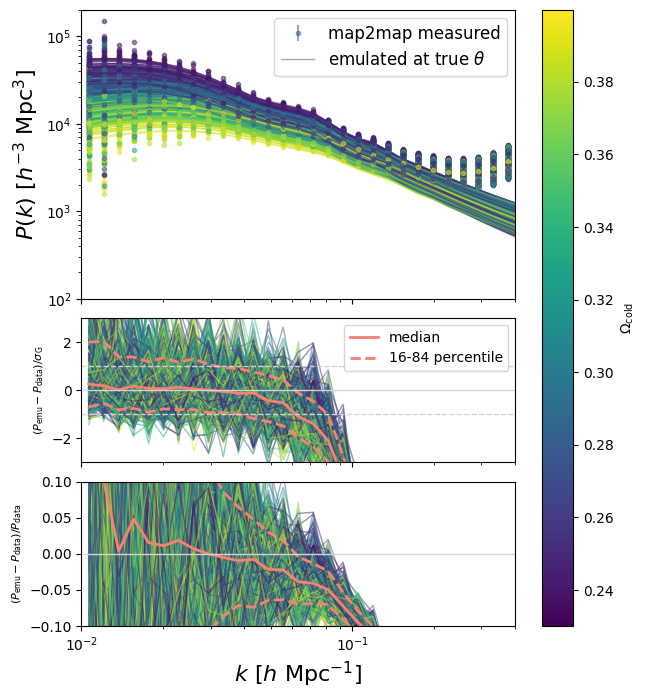

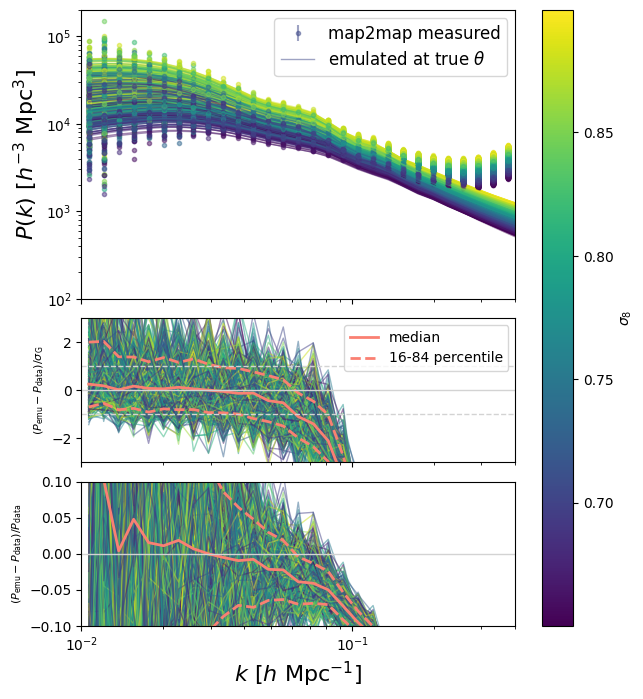

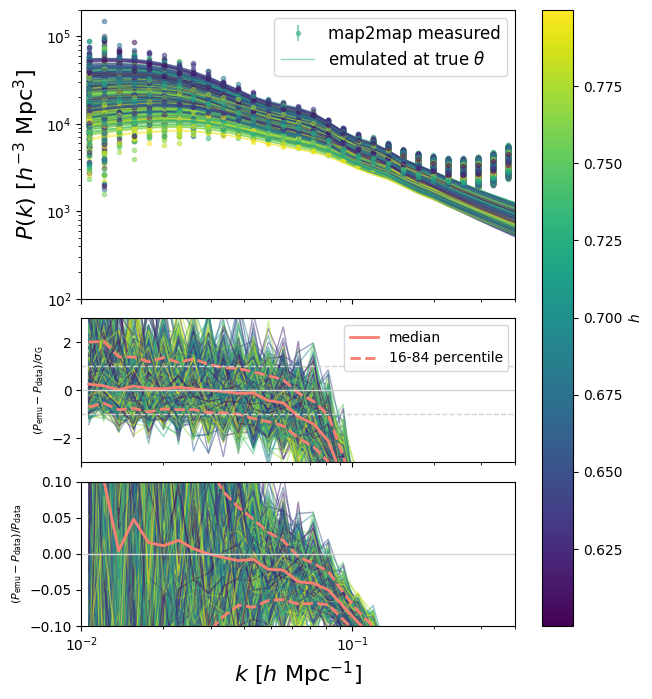

In [59]:
n_plot = n_lib

for pp, param_name_compare in enumerate(param_names):
#for pp, param_name_compare in enumerate(param_names[:1]):

    idx_param = param_names.index(param_name_compare)
    param_vals = np.array([theta[i][idx_param] for i in range(n_lib)])
    
    normalizer = mpl.colors.Normalize(vmin=np.min(param_vals), vmax=np.max(param_vals))
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=mpl.cm.viridis)#.to_rgba(cvals)
    colors = sm.to_rgba(param_vals)
    
    nrows, ncols = 3, 1
    fig, axarr = plt.subplots(nrows, ncols, figsize=(7,8), sharex=True, height_ratios=[2,1,1])
    plt.subplots_adjust(hspace=0.1)
    ax, ax1, ax2 = axarr

    lw = 1
    show_error_all = False
    first = True

    k = kk
    for i in range(n_plot):
        
        label_true, label_emu, label_stdev = None, None, None
        if first:
            label_true = 'map2map measured'
            label_emu = r'emulated at true $\theta$'
            label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
        
        if first or show_error_all:
            axarr[0].errorbar(k, Pk[i], yerr=gaussian_error_pk[i], 
                            ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        else:
            axarr[0].plot(k, Pk[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        
        axarr[0].plot(k, Pk_emu_mm[i], ls='-', alpha=0.5, label=label_emu, color=colors[i], lw=lw)

        axarr[1].plot(k, (Pk_emu_mm[i]-Pk[i])/gaussian_error_pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        axarr[2].plot(k, (Pk_emu_mm[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        
        first = False
        
    # whole set 16-84
    diff_Pk = Pk_emu_mm - Pk
    diff_overG = diff_Pk/gaussian_error_pk
    diff_overG_16 = np.percentile(diff_overG, 16, axis=0)
    diff_overG_84 = np.percentile(diff_overG, 84, axis=0)
    diff_overG_med = np.median(diff_overG, axis=0)

    diff_overPk = diff_Pk/Pk
    diff_overPk_16 = np.percentile(diff_overPk, 16, axis=0)
    diff_overPk_84 = np.percentile(diff_overPk, 84, axis=0)
    diff_overPk_med = np.median(diff_overPk, axis=0)

    alpha_16_84 = 0.5
    axarr[1].plot(k, diff_overG_med, color='salmon', lw=2, label='median')
    axarr[1].plot(k, diff_overG_16, color='salmon', lw=2, ls='--', label='16-84 percentile')
    axarr[1].plot(k, diff_overG_84, color='salmon', lw=2, ls='--')
    
    axarr[2].plot(k, diff_overPk_med, color='salmon', lw=2)
    axarr[2].plot(k, diff_overPk_16, color='salmon', lw=2, ls='--')
    axarr[2].plot(k, diff_overPk_84, color='salmon', lw=2, ls='--')

    ls_1sig='--'
    axarr[1].axhline(-1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[1].axhline(1, color='lightgrey', lw=1, ls=ls_1sig)

    # axarr[1].fill_between(k, diff_overG_16, diff_overG_84, color='salmon', alpha=alpha_16_84,
    #                       zorder=10000,
    #                     label='16-84 percentile of training set')
    # axarr[2].fill_between(k, diff_overPk_16, diff_overPk_84, color='salmon', zorder=10000, alpha=alpha_16_84)
    # axarr[3].fill_between(k, ratio_16, ratio_84, color='salmon', zorder=10000, alpha=alpha_16_84)
           
    color_hline = 'lightgrey'
    axarr[1].axhline(0, color=color_hline, lw=1)
    axarr[2].axhline(0, color=color_hline, lw=1)

    # plot settings
    plt.xscale('log')
    axarr[0].set_yscale('log')
        
    plt.xlim(1e-2, 0.4)
    #axarr[0].set_ylim(1e3, 5e5)
    axarr[0].set_ylim(1e2, 2e5)

    axarr[1].set_ylim(-3, 3)
    axarr[2].set_ylim(-0.1, 0.1)
        
    handles, labels = axarr[0].get_legend_handles_labels()
    print(handles, labels)
    #order = [1,0,2]
    order = [1,0]
    axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
    # axarr[0].legend(fontsize=12)
    handles, labels = axarr[1].get_legend_handles_labels()
    print(handles, labels)
    #axarr[1].legend(fontsize=10)

    axarr[1].legend(fontsize=10)

    axarr[-1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
    axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)    
    axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{data})/\sigma_\text{G}$', fontsize=8)
    axarr[2].set_ylabel(r'$(P_\text{emu}-P_\text{data})/P_\text{data}$', fontsize=8)

    cbar = plt.colorbar(sm, ax=axarr.ravel().tolist())
    cbar.set_label(utils.param_label_dict[param_name_compare])